## First Generation: Price Sequences

The first generation of microstructure models focused on estimating bid-ask spreads and volatility as proxies for illiquidity. These models estimated these measures using limited data without imposing strategic or sequential structures on the trading process.
End of Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_parquet('./research/Data/AAPL_tick.parquet')

### The Tick Rule

In a double auction order book, bids and offers are presented at various price levels to either sell or buy securities. The ask price always exceeds the bid price, as otherwise an immediate match would occur. Transactions happen when buyers match the ask price or sellers match the bid price. While every trade has both a buyer and seller, only one side initiates the trade.

The tick rule is an algorithm to determine the aggressor side in a trade. Following this logic, buyer-initiated trades are labeled as 1 and seller-initiated trades as -1:

$$
b_t=
\begin{cases}
1 & \text{if } \Delta p_t > 0\\
-1 & \text{if } \Delta p_t < 0\\
b_{t-1} & \text{if } \Delta p_t = 0
\end{cases}
$$


Here $p_t$ represents the transaction price indexed at $t=1,\cdots, T$, and $b_0$ is arbitrarily set to 1. Numerous studies have shown that despite its relative simplicity, the tick rule achieves high classification accuracy. Transformations of the $\{b_t\}$ series can create informative features, including:

1. Kalman Filter for future expectations $E_t[b_{t+1}]$
2. Structural breaks in these predictions
3. Entropy of the $\{b_t\}$ sequence
4. t-values from Wald-Wolfowitz tests on $\{b_t\}$ runs
5. Fractionally differentiated features of the cumulative $\{b_t\}$ series $\sum_{t=1}^t b_t$

In [2]:
from quant_free.finml.features.microstructure import *

tick_side = tick_rule(data['Price'])

In [3]:
tick_side.head()

2023-04-03 09:30:00    1.0
2023-04-03 09:30:00   -1.0
2023-04-03 09:30:00    1.0
2023-04-03 09:30:00   -1.0
2023-04-03 09:30:00   -1.0
dtype: float64

In [3]:
data['Side'] = tick_side

### The Roll Model of Trade Prices

Roll (1984) is one of the first models to explain the effective bid-ask spread at which securities are traded. It is known as an early attempt to quantify the liquidity of securities and is one of the most famous models that pioneered the field of Market Microstructure.

#### Random walk model of security prices

Let's assume a price $p_t$ traded at time $t$. Here, the time index $t$ can be an hourly interval, a minute, or even a day. We'll refer to this time as calendar time from now on. The price series $p_t$ following a random walk is assumed to follow:

$p_t = p_{t - 1} + \mu + u_t$

Here, $u_t, t \in \{0,\dots, T\}$ is a white noise series and a random variable following an iid process. Intuitively, when new information reaches the market, prices change. $\mu$ represents the market's expected price change level $(E[\Delta p_t])$. If the market expects prices to neither rise nor fall (a sideways or static market), then $\mu = 0$. In this situation, since the price $p_t = p_{t-1} + u_t$, it follows a random walk process. Therefore, in this case, price prediction is completely impossible (this process is called a martingale process).

However, in reality, it's rare to see prices perfectly following a random walk process. In securities markets, there are not only sellers and buyers but also information-based traders, liquidity providers, and brokers. These intermediaries facilitate smooth trading liquidity and matching while taking fees. Therefore, it's a market where bid price and ask price coexist simultaneously.

#### The Roll Model of bid, ask, and Transaction prices

Roll considered a mid-price series $m_t$ between bid price and ask price. Let's assume a trendless random walk process $\{m_t\}$ as follows:

$m_t = m_{t-1} + u_t$

The change in mid-price $\Delta m_t = m_t - m_{t-1}$ is independently and identically drawn from a normal distribution:

$\Delta m_t \sim N(0, \sigma_u^2)$

The observed price $\{p_t\}$ is the result of sequential trades with spread added to the mid-price series $\{m_t\}$:

$p_t = m_t + b_tc$

Here, $c$ is half of the bid-ask spread and $b_t \in \{-1, 1\}$ represents the trade direction (side) of aggressive traders. The Roll Model assumes that buy and sell probabilities are equal ($P[b_t = 1] = P[b_t = -1] = \frac{1}{2}$), series independence ($E[b_t b_{t-1}] = 0$), and $E[b_tu_t] = 0$. Under these assumptions, the values of $c$ and $\sigma_u^2$ can be derived as:

$\sigma^2[\Delta p_t] = E\left[ (\Delta p_t)^2 \right] - \left(E[(\Delta p_t)] \right)^2 = 2c^2 + \sigma_u^2$
$\sigma\left[\Delta p_t, \Delta p_{t-1}\right] = - c^2$

Solving these equations gives the spread estimator $c = \sqrt{\max\{0, -\sigma[\Delta p_t, \Delta p_{t-1}]\}}$ and volatility estimator $\sigma_u^2 = \sigma^2[\Delta p_t] + 2\sigma[\Delta p_t, \Delta p_{t-1}]$. In other words, the bid-ask spread is a function of the covariance of price change series, and the unobserved price noise with market microstructure noise removed is a function of observed noise $(\sigma^2[\Delta p_t])$ and the covariance of price change series $(\sigma[\Delta p_t, \Delta p_{t-1}])$.

The spread $c$ estimated from the Roll Model has the following implications:

1. Measure of transaction costs: The spread estimated by the Roll Model represents the average transaction cost incurred by market participants when executing trades. These costs mainly arise from information asymmetry between buyers and sellers, order execution risk, and lack of market liquidity.
2. Indicator of market liquidity: A low spread indicates high market liquidity, meaning investors can buy and sell assets at relatively low transaction costs. Conversely, a high spread indicates low liquidity, meaning investors must bear higher transaction costs. In other words, as the spread widens, it indirectly indicates market imbalance.
3. Measure of information efficiency: The spread estimate from the Roll Model can be used to indirectly assess market information efficiency. A wider spread can be interpreted as indicating greater information asymmetry among market participants. That is, a smaller spread means information is more publicly available.

Another strength of the Roll Model is that it can be used as a measure of market imbalance not only in stock markets but also in less-traded asset-based security markets or real estate transactions. However, the Roll Model also has weaknesses: it ignores price change causes other than transaction costs, and its assumption that all market participants experience the same spread is unrealistic. Additionally, the assumption that the mid-price series $\{m_t\}$ is an iid series is also unrealistic and should be considered.

In [4]:
roll_value = roll_measure(close_prices = data['Price'])

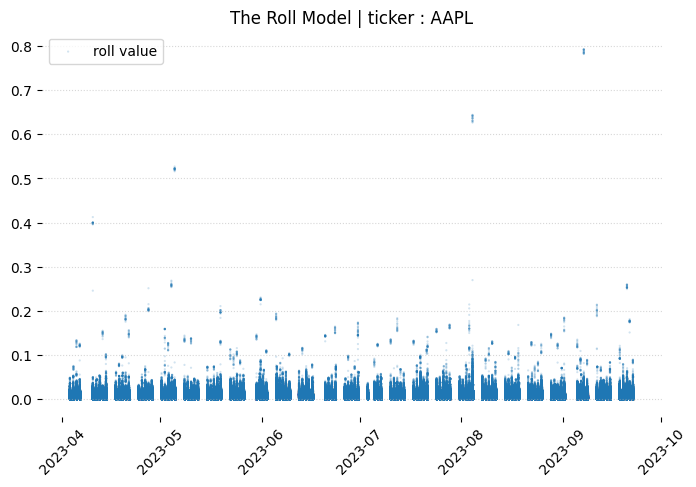

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    roll_value.index, 
    roll_value,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.2,
    s = 10,
    label = 'roll value'
)

# ax.plot(
#     roll_value.index, 
#     data['Price'].diff(),
#     color = 'red',
#     alpha = 0.5,
#     linewidth = 1,
#     label = 'price diff'
# )

for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('The Roll Model | ticker : AAPL')
plt.show()

### High-Low Volatility Estimator

Parkinson (1980) derived the following for continuously observed prices following geometric Brownian motion:

$E\Big[ \frac{1}{T} \sum_{t=1}^T \Big( \log\Big[\frac{H_t}{L_t}\Big]\Big)\Big] = k_1\sigma_{HL}^2$

$E\Big[ \frac{1}{T} \sum_{t=1}^T \Big( \log\Big[\frac{H_t}{L_t}\Big]\Big)\Big] = k_2\sigma_{HL}$

where $k_1 = 4\log(2)$, $k_2 = \sqrt{\frac{8}{\pi}}$, $H_t$ is the high price for bar t, and $L_t$ is the low price for bar t. Then the volatility characteristic $\sigma_{HL}$ can be reliably calculated based on the observed high-low prices.

$ \sigma_{HL} = \sqrt{ \frac{1}{4k\log(2)} \cdot \frac{1}{T} \sum_{t=1}^T \left[ \log\left(\frac{H_t}{L_t}\right) \right]^2 } $ where $k = \sqrt{\frac{8}{\pi}} \approx 1.595769$




In [7]:
data_ohlc = data['Price'].resample('1T').ohlc()

In [8]:
data_ohlc['volume'] = data['Volume'].resample('1T').sum()

In [9]:
data_ohlc.head()

,open,high,low,close,volume
2023-04-03 09:30:00,164.27,164.90,164.25,164.770,44082
2023-04-03 09:31:00,164.79,164.90,164.73,164.765,7503
2023-04-03 09:32:00,164.84,164.84,164.66,164.660,3380
2023-04-03 09:33:00,164.64,164.98,164.61,164.980,6954
2023-04-03 09:34:00,164.99,165.55,164.98,165.490,31658


In [10]:
vol = becker_parkinson_vol(high = data_ohlc['high'], low = data_ohlc['low'])

In [11]:
vol.dropna().head()

2023-04-03 09:50:00    0.000000
2023-04-03 09:51:00    0.000000
2023-04-03 09:52:00    0.000000
2023-04-03 09:53:00    0.001210
2023-04-03 09:54:00    0.003081
dtype: float64

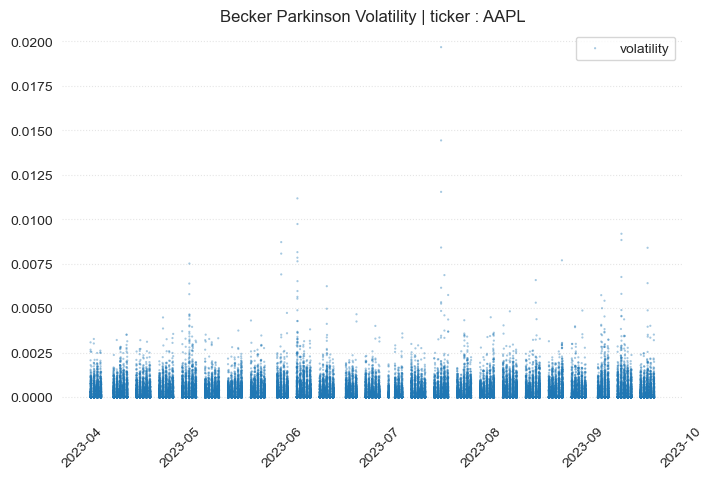

In [12]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    vol.index, 
    vol,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.4,
    s = 10,
    label = 'volatility'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Becker Parkinson Volatility | ticker : AAPL')
plt.show()

### Corwin and Schultz

Corwin and Schultz introduced a bid-ask spread estimator based on high and low prices, building upon Becker's research. The estimator is based on two principles. First, the high price almost always matches the ask price, and the low price matches the bid price. The ratio of high to low prices reflects both fundamental volatility and bid-ask spread. Second, the volatility-induced component of the bid-ask ratio increases proportionally with the time elapsed between two observations.

Corwin and Schultz showed that the bid-ask spread can be calculated as a percentage of price using the following formula:

$S_t = \frac{2(e^{\alpha_t}-1)}{1+e^{\alpha_t}}$

where

$\alpha_t = \frac{\sqrt{2\beta_t} - \sqrt{\beta_t}}{3 - 2\sqrt{2}} - \sqrt{\frac{\gamma_t}{3-2\sqrt{2}}}$
$\beta_t = E \Big[\sum_{j=0}^1 \Big[\log \Big(\frac{H_{t-j}}{L_{t-j}} \Big) \Big]^2\Big]$
$\gamma_t = \Big[\log \Big(\frac{H_{t-1, t}}{L_{t-1, t}}\Big) \Big]^2$

$H_{t-1,t}$ is the high price over two periods, and $L_{t-1,t}$ is the low price over two periods. Volatility is not explicitly visible in the Corwin-Schultz formula because it has been replaced by the high/low price estimator. This model can be used to derive Becker-Parkinson volatility. This spread estimator is particularly useful in corporate bond markets where there is no centralized order book and trading occurs through Bids Wanted In Competition (BWIC). The resulting bid-ask spread characteristic can be repeatedly calculated over a moving average window and then smoothed using a Kalman Filter.

In [13]:
spread = corwin_schultz_estimator(high = data_ohlc['high'], low = data_ohlc['low'])

In [14]:
spread.dropna().head()

2023-04-03 09:50:00    0.002139
2023-04-03 09:51:00    0.002831
2023-04-03 09:52:00    0.002704
2023-04-03 09:53:00    0.000000
2023-04-03 09:54:00    0.000000
Name: Spread, dtype: float64

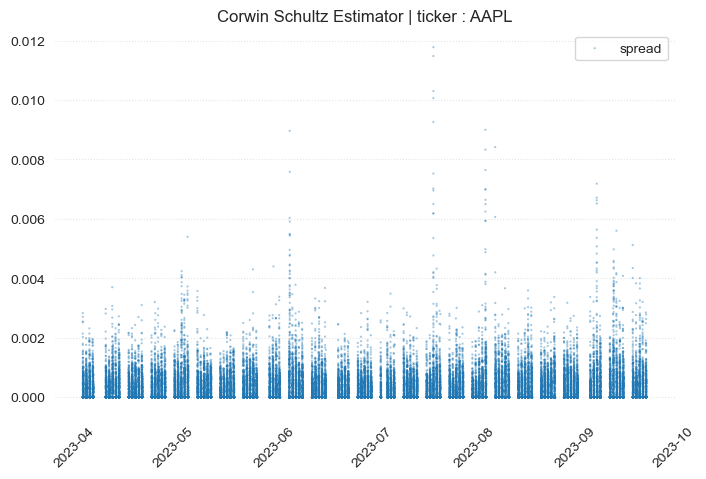

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    spread.index, 
    spread,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.4,
    s = 10,
    label = 'spread'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Corwin Schultz Estimator | ticker : AAPL')
plt.show()